In [1]:
! pip install googletrans stopwordsiso wordcloud

In [1]:
import json

import pandas as pd

import scipy.stats as stats

from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
data = json.load(open(f'../{data_dir}/labelbox_sample_annotated.json'))
data.keys()

dict_keys(['d16ec044', '3fefb024'])

In [3]:
dfs = []
for annotator in data.keys():
    df_annotator = pd.DataFrame.from_records(data[annotator])
    df_annotator['annotator'] = annotator
    dfs.append(df_annotator)

df = pd.concat(dfs)
df["trigger_level"] = df["trigger_level"].astype(int)

In [4]:
df.columns

Index(['emotion', 'emotion_class', 'trigger_level', 'context',
       'context_locations', 'description', 'created_at', 'created_by', 'text',
       'id', 'annotator'],
      dtype='object')

In [5]:
df.head(2)

,emotion,emotion_class,trigger_level,context,context_locations,description,created_at,created_by,text,id,annotator
0,anger,negative,4,[США по разным каналам пытаются убедить своих ...,"[[300, 452]]",None,2024-05-03T09:23:42.000+00:00,d16ec044,"Путин: Те, кто планировали этот теракт, рассчи...",e19f77b7-f1a3-4f8a-b160-4af23deef647,d16ec044
1,undefined,positive,1,[],[],None,2024-05-03T09:32:28.000+00:00,d16ec044,«Чадыр-Лунга — город на семи холмах»: в Гагауз...,667ec738-34fe-4ced-b193-f97c47c4c9ce,d16ec044


In [7]:
df_d16ec044 = df[df.annotator == 'd16ec044'].sort_values(by='id')
df_3fefb024 = df[df.annotator == '3fefb024'].sort_values(by='id')
df_d16ec044.shape, df_3fefb024.shape

((236, 11), (236, 11))

In [8]:
def get_location_len(location):
    try:
        return location[1]-location[0]
    except:
        return None

df_d16ec044.explode('context_locations')['context_locations'].apply(get_location_len).mean()

47.621428571428574

In [9]:
df_3fefb024.explode('context_locations')['context_locations'].apply(get_location_len).mean()

18.590551181102363

In [10]:
df['annotator_for'] = df['created_by'].map({'d16ec044': 'persona_1', '3fefb024': 'persona_2'})

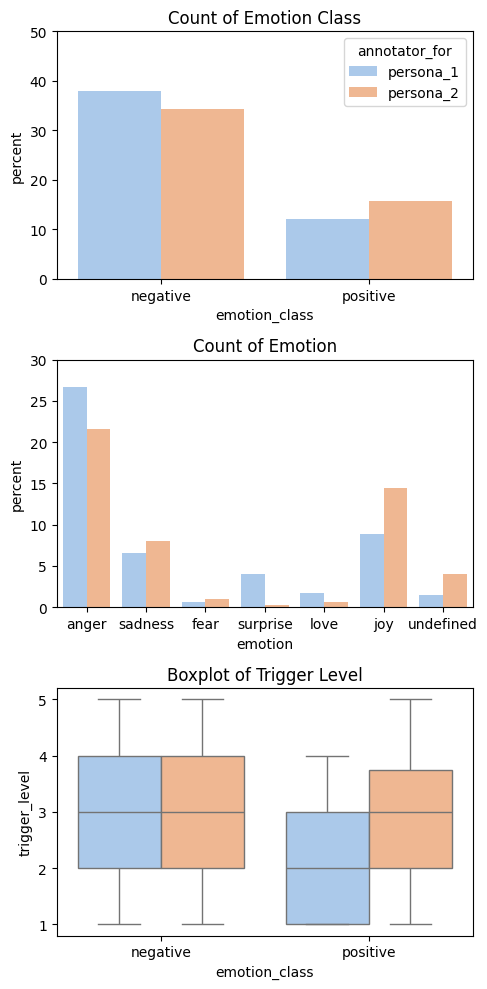

In [11]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 10))

plt.subplot(3, 1, 1)
ax11 = sns.countplot(data=df, x='emotion_class', hue='annotator_for', order=["negative", "positive"], stat='percent', palette='pastel')
ax11.set_ylim(0, 50)
plt.title('Count of Emotion Class')

plt.subplot(3, 1, 2)
a12 = sns.countplot(data=df, x='emotion', hue='annotator_for',
                    order=["anger", "sadness", "fear", "surprise", "love", "joy", "undefined"], stat='percent', palette='pastel',
                   legend=False)
a12.set_ylim(0, 30)
plt.title('Count of Emotion')

plt.subplot(3, 1, 3)
a13 = sns.boxplot(data=df, y='trigger_level', x='emotion_class', hue='annotator_for', order=["negative", "positive"], palette='pastel',
                 legend=False)
# a13.set_ylim(0, 30)
plt.title('Boxplot of Trigger Level')

# Display the plots
plt.tight_layout()
plt.savefig('eda.png')
plt.show()

In [12]:
df.trigger_level.describe()

count    472.000000
mean       2.855932
std        1.178544
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: trigger_level, dtype: float64

In [13]:
### Categorical Variables: 'emotion' and 'emotion_class'
# Chi-Squared Test for 'emotion'
contingency_emotion = pd.crosstab(df_d16ec044['emotion'], df_3fefb024['emotion'])
_, p_emotion, _, _ = stats.chi2_contingency(contingency_emotion)

# Chi-Squared Test for 'emotion_class'
contingency_emotion_class = pd.crosstab(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])
_, p_emotion_class, _, _ = stats.chi2_contingency(contingency_emotion_class)

print()
print("Chi-Squared Test for Emotion:")
print("P-value =", p_emotion)

print("Chi-Squared Test for Emotion Class:")
print("P-value =", p_emotion_class)

print()
print("Normality Test for Trigger Level:")
_, p_value_1 = stats.normaltest(df_d16ec044['trigger_level'])
_, p_value_2 = stats.normaltest(df_3fefb024['trigger_level'])
print(f"Normality Test P-value For d16ec044 =", p_value_1)
print(f"Normality Test P-value For 3fefb024 =", p_value_2)

# Using Mann-Whitney U Test as a non-parametric alternative if normality is not assumed
u_stat, p_trigger = stats.mannwhitneyu(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'], alternative='two-sided')

print("Mann-Whitney U Test for Trigger Level:")
print("P-value =", p_trigger)


Chi-Squared Test for Emotion:
P-value = 5.944718173448189e-09
Chi-Squared Test for Emotion Class:
P-value = 0.26886250893495856

Normality Test for Trigger Level:
Normality Test P-value For d16ec044 = 2.118182467941346e-08
Normality Test P-value For 3fefb024 = 0.00041765766574110617
Mann-Whitney U Test for Trigger Level:
P-value = 0.025205095567695023


In [14]:
n_stats, p_value = stats.normaltest(df_3fefb024['trigger_level'])
p_value

0.00041765766574110617

# Annotation agreement

In [15]:
cohen_kappa_score(df_d16ec044['emotion'], df_3fefb024['emotion'])

0.016131955773065032

In [16]:
cohen_kappa_score(df_d16ec044['emotion_class'], df_3fefb024['emotion_class'])

-0.08131672597864759

In [17]:
cohen_kappa_score(df_d16ec044['trigger_level'], df_3fefb024['trigger_level'])

0.12237261514297593

# Context evaluation

In [18]:
def calc_span_intersection(true_context: list[tuple], predicted_context: list[tuple]):
    correct_pairs = []
    for true_start, true_end in true_context:
        true_chars = list(range(true_start, true_end + 1))
        for pred_start, pred_end in predicted_context:
            pred_chars = list(range(pred_start, pred_end + 1))
            intersection = sorted(set(true_chars).intersection(set(pred_chars)))
            if not intersection:
                continue
            correct_pairs.append((intersection[0], intersection[-1]))
    return correct_pairs

def calc_proportional_overlap(ann1_labels, ann2_labels):
    overlap_labels_total, overlap_labels_len = 0, 0
    ann1_labels_total, ann1_labels_len = 0, 0
    ann2_labels_total, ann2_labels_len = 0, 0
    overlaps_all = []
    for i, (ann1_labels_i, ann2_labels_i) in enumerate(zip(ann1_labels, ann2_labels)):
        ann1_labels_len += sum([e - s + 1 for s, e in ann1_labels_i])
        ann2_labels_len += sum([e - s + 1 for s, e in ann2_labels_i])
        # print(ann1_labels_len, ann2_labels_len)
        ann1_labels_total += len(ann1_labels_i)
        ann2_labels_total += len(ann2_labels_i)
        # print(ann1_labels_total, ann2_labels_total)
        overlaps = calc_span_intersection(ann1_labels_i, ann2_labels_i)
        overlaps_all.append(overlaps)
        overlap_labels_len += sum([e - s + 1 for s, e in overlaps])
        overlap_labels_total += len(overlaps)
        # print(overlap_labels_len, overlap_labels_total)
    return {
        "ann1_labels_len": ann1_labels_len, "ann1_labels_total": ann1_labels_total,
        "ann2_labels_len": ann2_labels_len, "ann2_labels_total": ann2_labels_total,
        "overlap_labels_len": overlap_labels_len, "overlap_labels_total": overlap_labels_total,
        "overlaps_all": overlaps_all,
    }

res = calc_proportional_overlap(df_d16ec044['context_locations'], df_3fefb024['context_locations'])

In [19]:
res['ann1_labels_len'] / res['ann1_labels_total'], res['ann2_labels_len'] / res['ann2_labels_total']

(48.621428571428574, 19.590551181102363)

In [20]:
(res['overlap_labels_len' ]) / (res['ann1_labels_len'] + res['ann2_labels_len'] - res['overlap_labels_len' ])

0.14203795092792104

# Overlaps

In [21]:
df_new = pd.DataFrame({
    'd16ec044': df_d16ec044['context_locations'],
    '3fefb024': df_3fefb024['context_locations'],
    'text': df_3fefb024['text'],
    'overlaps': res['overlaps_all'],
})

text_overlaps = []
for i, row in df_new.iterrows():
    text = row['text']
    text_overlap = [text[o[0]:o[1]+1] for o in row['overlaps']]
    text_overlaps.append(text_overlap)

df_new['text_overlaps'] = text_overlaps

In [22]:
text_overlap = ' '.join(df_new['text_overlaps'].apply(lambda x: ' '.join(x)).values)

In [23]:
from googletrans import Translator
import matplotlib.pyplot as plt

# Initialize the translator
translator = Translator()

# Function to translate text
def translate_to_english(text):
    try:
        translation = translator.translate(text, dest='en')
        return translation.text
    except Exception as e:
        return text

# Translate the text column to English
text_overlap_translated = translate_to_english(text_overlap)

In [24]:
import stopwordsiso

stopwordsiso.stopwords('en')

{'significantly',
 'theyd',
 'ma',
 'vu',
 'k',
 'and',
 'bb',
 'int',
 'ca',
 'five',
 'smallest',
 'werent',
 'they',
 'recent',
 "who'll",
 'didn',
 'pe',
 'give',
 'man',
 'whilst',
 'thru',
 'parting',
 'hid',
 'ourselves',
 'fify',
 'kz',
 'downed',
 'indeed',
 'means',
 'saying',
 'mo',
 "we've",
 'better',
 'ff',
 'due',
 'really',
 'similarly',
 'longest',
 'truly',
 'suggest',
 'say',
 'find',
 'bm',
 'order',
 'need',
 'newer',
 'oughtnt',
 'our',
 'call',
 'thatve',
 'bz',
 'webpage',
 'hopefully',
 'turned',
 'noted',
 'these',
 'vn',
 'greatest',
 'ts',
 'copy',
 'tm',
 'lt',
 'that',
 'iq',
 'going',
 'through',
 'gb',
 'substantially',
 "where'd",
 'bj',
 'td',
 'anything',
 'io',
 'invention',
 "we'd",
 'alongside',
 'goes',
 'want',
 'whose',
 'shown',
 'first',
 'oldest',
 'g',
 "shan't",
 'areas',
 'ran',
 'hereby',
 'differ',
 'za',
 'et-al',
 'om',
 'certainly',
 'ahead',
 'tends',
 'at',
 'opening',
 "'ve",
 'sa',
 'began',
 'f',
 'works',
 'biol',
 'seen',
 'pre

In [27]:
from wordcloud import WordCloud

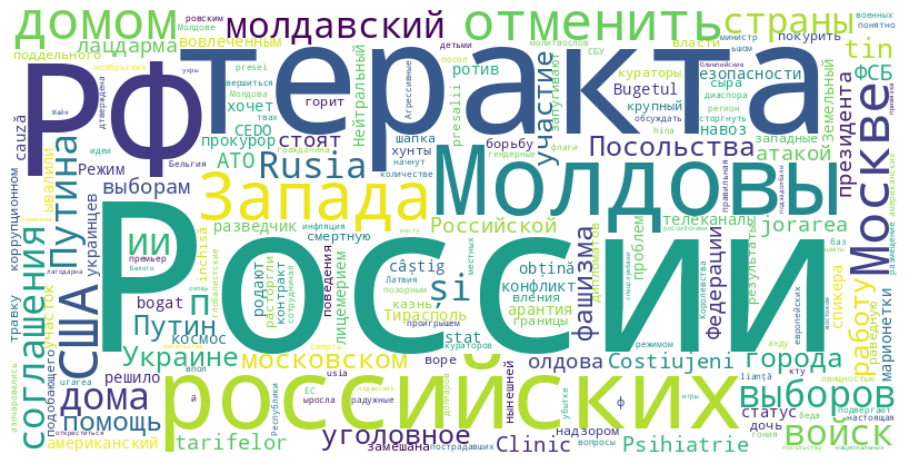

In [86]:
stopwords = stopwordsiso.stopwords('ro').union(stopwordsiso.stopwords('ru'))
wordcloud_original = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(text_overlap)
# wordcloud_translated = WordCloud(width=800, height=400, background_color='white',
#                                  stopwords=stopwordsiso.stopwords('en')).generate(text_overlap_translated)

# Plotting the word clouds
plt.figure(figsize=(10, 5))

# Display the word clouds
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.axis('off')

plt.tight_layout(pad=2.0)

plt.savefig('wordcloud.png')
plt.show()

In [42]:
print(wordcloud_original.words_.keys())

dict_keys(['России', 'теракта', 'РФ', 'российских', 'Молдовы', 'Запада', 'Москве', 'США', 'домом', 'отменить', 'выборов', 'Путина', 'соглашения', 'дома', 'ии', 'молдавский', 'Rusia', 'și', 'войск', 'страны', 'п', 'Украине', 'участие', 'московском', 'Посольства', 'города', 'фашизма', 'помощь', 'уголовное', 'tin', 'Путин', 'работу', 'jorarea', 'tarifelor', 'Clinic', 'Psihiatrie', 'Costiujeni', 'выборам', 'президента', 'Российской', 'Федерации', 'олдова', 'АТО', 'лацдарма', 'ФСБ', 'атакой', 'стоят', 'американский', 'разведчик', 'лицемерием', 'Тирасполь', 'хочет', 'вовлеченным', 'конфликт', 'Bugetul', 'stat', 'bogat', 'obțină', 'câștig', 'cauză', 'CEDO', 'телеканалы', 'ывалили', 'навоз', 'спикера', 'Режим', 'Нейтральный', 'статус', 'арантия', 'езопасности', 'ротив', 'украинцев', 'космос', 'решило', 'проблем', 'прокурор', 'марионетки', 'Земельный', 'участок', 'родают', 'поддельного', 'сыра', 'смертную', 'казнь', 'покурить', 'травку', 'вления', 'подобающего', 'поведения', 'ф', 'воре', 'шапка

# Best triggers

In [47]:
df[df.emotion_class == 'positive'].value_counts('emotion')

emotion
joy          109
love          11
surprise       6
undefined      3
sadness        2
dtype: int64

In [48]:
df[df.emotion_class == 'negative'].value_counts('emotion')

emotion
anger        228
sadness       67
undefined     23
surprise      14
fear           8
joy            1
dtype: int64

In [54]:
df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))].value_counts('annotator_for')

annotator_for
persona_1    62
persona_2    54
dtype: int64

In [79]:
df_p1_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([5]))&(df.annotator_for == 'persona_1')]['context']
df_p2_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([5]))&(df.annotator_for == 'persona_2')]['context']

In [80]:
len(df_p1_triggers), len(df_p2_triggers)

(12, 25)

In [81]:
' '.join(df_p1_triggers.apply(' '.join).values)

'Гуцул не исключает, что Кишинев пойдет на ввод войск и роспуск Гагаузской автономии в случае объявления ею независимости Башкан сделала то, чего ждал весь гагаузский народ и часть жителей остальной РМ Хозяева Майи Санду как верная собака западные кураторы режим Майи Санду не только выставили себя на посмешище границы диктатуры и беспредела они могут расширять бесконечно пострадавшим ❗️Полякова, ITV принять на работу людей, которые потеряли работу празднуя 80-летие освобождения города от фашизма, школьники поют Катюшу выставку военной атрибутики партии «Возрождение» участие в московском форуме — это значимый шаг для нас визит в Российскую Федерацию горизонты для укрепления молдо-российских связей На встречах с ключевыми лицами российского общества мы нашли понимание нормализации отношений между нашими странами число сторонников партии «Возрождение» продолжает расти наше движение охватит каждый уголок Республики Молдова ‼️Марина Таубер лишить меня мандата сажали под предварительный арес

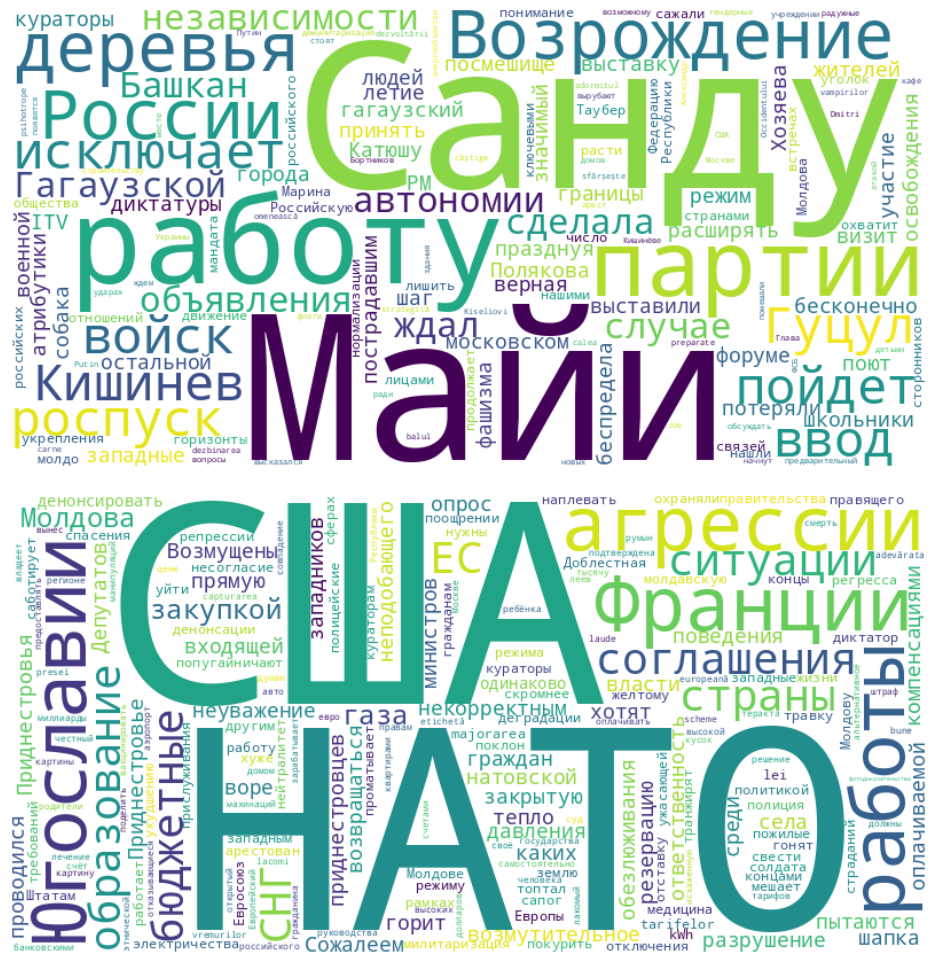

In [83]:
stopwords = stopwordsiso.stopwords('ro').union(stopwordsiso.stopwords('ru'))
wordcloud1 = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(' '.join(df_p1_triggers.apply(' '.join).values))
wordcloud2 = WordCloud(width=800, height=400, background_color='white',
                               stopwords=stopwords).generate(' '.join(df_p2_triggers.apply(' '.join).values))

plt.figure(figsize=(10, 10))  # Set the figure size

# First word cloud
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
# plt.title('Word Cloud 1')

# Second word cloud
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
# plt.title('Word Cloud 2')

# Show the plot
plt.tight_layout(pad=2.0)

plt.savefig('wordcloud_biggest_triggers.png')
plt.show()

In [ ]:
df_p1_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_1')]['context']
df_p2_triggers = df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_2')]['context']

In [71]:
df[(df.emotion_class == 'negative')&(df.trigger_level.isin([4, 5]))&(df.annotator_for == 'persona_1')]

,emotion,emotion_class,trigger_level,context,context_locations,description,created_at,created_by,text,id,annotator,annotator_for
0,anger,negative,4,[США по разным каналам пытаются убедить своих ...,"[[300, 452]]",None,2024-05-03T09:23:42.000+00:00,d16ec044,"Путин: Те, кто планировали этот теракт, рассчи...",e19f77b7-f1a3-4f8a-b160-4af23deef647,d16ec044,persona_1
11,anger,negative,4,[ЕС — это настоящая беда для Молдовы. И тогда ...,"[[648, 719], [257, 347]]",This post triggers negatives emotions because ...,2024-05-02T17:24:52.000+00:00,d16ec044,Вице-спикер парламента Дойна Герман вместе с п...,56046867-52f4-4acb-b099-5c6c6ef50e22,d16ec044,persona_1
12,anger,negative,4,"[«отменить» молдавский язык, румынскийнет]","[[364, 389], [509, 520]]",It triggers strong negative emotions because t...,2024-05-02T17:37:02.000+00:00,d16ec044,"После слов Владимира Воронина о том, что «они ...",96679543-8183-4a81-87e7-d27dfe7ee194,d16ec044,persona_1
13,anger,negative,4,"[Богдан Цырдя, Виктории Фуртунэ, закрыла уголо...","[[0, 11], [63, 78], [186, 219]]",None,2024-05-03T08:42:57.000+00:00,d16ec044,Богдан Цырдя прокомментировал новое заявление ...,fd4aa3f7-4a60-4db8-9d3c-b38e2d09e756,d16ec044,persona_1
14,anger,negative,4,[когда русские люди с оружием в руках смешали ...,"[[83, 171], [450, 504]]",None,2024-05-03T08:44:49.000+00:00,d16ec044,‼️10 лет войны на Донбассе ⚡️12 апреля 2014 го...,2f16fa3c-d1a4-4b5d-9176-4548816d1f65,d16ec044,persona_1
...,...,...,...,...,...,...,...,...,...,...,...,...
216,anger,negative,4,[Молдова рассматривается странами НАТО в качес...,"[[3, 122], [335, 371]]",None,2024-05-04T16:53:08.000+00:00,d16ec044,🔸 Молдова рассматривается странами НАТО в каче...,0807d255-460d-4e72-a21f-22b0732b76f0,d16ec044,persona_1
219,anger,negative,4,"[разочаровались в Майе Санду, депутат Василе Б...","[[15, 41], [52, 70], [552, 599], [826, 879]]",None,2024-05-04T16:56:28.000+00:00,d16ec044,"🔸 Многие люди разочаровались в Майе Санду, счи...",44b34be5-219b-40e7-9971-237bb76f7036,d16ec044,persona_1
221,anger,negative,5,"[Глава ФСБ России, за атакой в ​​Москве стоят ...","[[9, 24], [38, 67], [149, 167]]",The post arouses anger because Russia as usual...,2024-05-04T17:00:22.000+00:00,d16ec044,"Reuters: Глава ФСБ России заявил, что за атако...",086b9341-18b6-4162-aa6a-bfa3b332cd5e,d16ec044,persona_1
222,anger,negative,5,"[Putin, Dmitri Kiseliovi, preparate psihotrope...","[[56, 60], [76, 91], [265, 285], [476, 498], [...",The post arouses anger because Putin is delusi...,2024-05-04T17:02:53.000+00:00,d16ec044,🇷🇺Cele mai importante citate din interviul aco...,bc242e70-c4a2-45fc-a55c-6c36b9ac71d1,d16ec044,persona_1


______________________